In [1]:
%reset -f

import os
import torch
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
from torch import optim
from PIL import Image

torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using:", device)

nz = 256 # Size of z latent vector (i.e. size of generator input)

using: cuda


In [2]:
# for colab

from google.colab import drive
drive.mount('/content/drive')

!cp ./drive/MyDrive/dataset.zip ./

!unzip dataset.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  dataset.zip
replace dataset/00000000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Create the Dataset

Create a dataset that uses all the images from both the validation and training sets. Apply a crop and resize to convert all the images to 64x64 to reduce the training time and make the network architechture easier to manage (going from a nzx1x1 latent vector to a square is easier than to a rectangle).

In [3]:
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.data = list()
        self.transform = transform
        
        files = os.listdir("dataset")

        for i, file in enumerate(files):
            if i % 50 == 0:
                print("\r",  np.around(100 * (i/len(files)), decimals=4), "%", " "*30, end="")
            self.data.append(self.transform(io.imread("dataset/" + file)))
            if self.data[-1].shape[0] != 3:
                self.data.pop()
                #print("\nwrong size\n")

        for i in range(len(self.data)):
            if i % 50 == 0:
                print("\r",  np.around(100 * (i/len(files)), decimals=4), "%", " "*30, end="")
            self.data[i] = self.data[i].to(device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.data[idx]

# define a transform to convert the images to the right format
transform = transforms.Compose([
        transforms.ToPILImage(),       
        #transforms.RandomRotation(degrees=(-20, 20)),
        #transforms.RandomPerspective(distortion_scale=0.3),
        #transforms.CenterCrop(160),
        transforms.Resize((144,256)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=0.5,std=0.2)
])

# create the dataset
train_set = LandscapeDataset(transform=transform)

# create the dataloader with a batch size of 256
batch_size = 200
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

 99.6293 %                               

## Visualise some of the transformed images

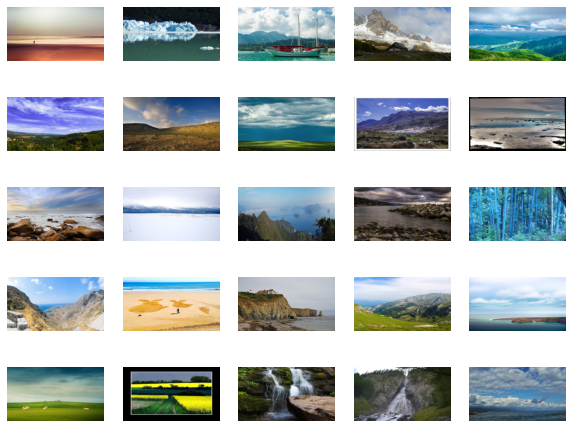

In [4]:
images = next(iter(train_loader))

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(images[i].cpu().permute(1, 2, 0))
plt.show()

## Define a generator

A traditional GAN generator design was used, with an input latent space of size nz x 1 x 1, that was doubled in resolution and halved in depth each layer. The first layer takes the depth to 512 dimensions and the last layer is 64 dimensions. This was the minimum value of `Gfs` that resulted in realistic faces being generated. Values, rising in powers of 2, were tried ranging from `Gfs = 16` to `Gfs = 256`.

In [5]:
Gfs = 64  # generator feature size

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #nz x 1 x 1
            nn.ConvTranspose2d(nz, 8*Gfs, kernel_size = (9,16), stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(8*Gfs),
            nn.ReLU(True),

            #8*Gfs x 16 x 9
            nn.ConvTranspose2d(8*Gfs, 4*Gfs, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(4*Gfs),
            nn.ReLU(True),

            #4*Gfs x 32 x 18
            nn.ConvTranspose2d(4*Gfs, 2*Gfs, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(2*Gfs),
            nn.ReLU(True),

            #2*Gfs x 64 x 36
            nn.ConvTranspose2d(2*Gfs, Gfs, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(Gfs),
            nn.ReLU(True),

            #Gfs x 128 x 72
            nn.ConvTranspose2d(Gfs, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Sigmoid()

            #3 x 256 x 144
        )

    def forward(self, input):
        return self.main(input)

netG = Generator()
netG = netG.to(device)

## Define a discriminator

A traditional GAN discriminator design was used, with an input image of size 1 x 96 x 80, that was halved in resolution and doubled in depth each layer. The first layer takes the depth to 16 dimensions and the last layer is 128 dimensions. 

In [6]:
Dfs = 16  # discriminator feature size

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #1 x 96 x 80
            nn.Conv2d(3, Dfs, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(Dfs),
            nn.LeakyReLU(0.2, inplace = True),

            #Dfs x 48 x 40
            nn.Conv2d(Dfs, 2*Dfs, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(2*Dfs),
            nn.LeakyReLU(0.2, inplace = True),

            #2*Dfs x 24 x 20
            nn.Conv2d(2*Dfs, 4*Dfs, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(4*Dfs),
            nn.LeakyReLU(0.2, inplace = True),

            #4*Dfs x 12 x 10
            nn.Conv2d(4*Dfs, 8*Dfs, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(8*Dfs),
            nn.LeakyReLU(0.2, inplace = True),

            #16*Dfs x 6 x 5
            nn.Conv2d(8*Dfs, 1, kernel_size = (9, 16), stride = 1, padding = 0, bias = False),

            #1 x 1 x 1
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator()
netD = netD.to(device)

## Optimiser and loss

In [7]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas = (0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas = (0.5, 0.999))

D_losses = []
G_losses = []

## Training loop

In [8]:
num_epochs = 300

netG.train()
netD.train()

for epoch in range(num_epochs):
    for i, images in enumerate(train_loader, 0):

        # UPDATE DISCRIMINATOR

        # training with real images

        netD.zero_grad()
        #real_images = images.to(device)
        label = torch.full((len(images),), real_label, dtype=torch.float, device=device)
        output = netD(images).view(-1)
        # if the current batch is not full, exit out. (bse loss will not work if the batch isn't full)
        if len(output) < batch_size:
            break
        D_loss_real = criterion(output, label)
        D_loss_real.backward()

        # training with fake iamges

        z = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(z)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        D_loss_fake = criterion(output, label)
        D_loss_fake.backward()

        # loss over both real and fake
        D_loss = D_loss_real + D_loss_fake
        
        # take optimiser step for D
        optimizerD.step()

        # UPDATE GENERATOR

        # update G with gradients from D's last run
        netG.zero_grad()
        label.fill_(real_label)  
        output = netD(fake).view(-1)
        G_loss = criterion(output, label)
        G_loss.backward()

        # take optimiser step for G
        optimizerG.step()

    print("epoch", epoch, "\tD loss:", D_loss.item(), "\tG loss:", G_loss.item())
    D_losses.append(D_loss)
    G_losses.append(G_loss)

epoch 0 	D loss: 3.147951126098633 	G loss: 1.6097054481506348
epoch 1 	D loss: 1.2547924518585205 	G loss: 3.5233938694000244
epoch 2 	D loss: 0.9964708685874939 	G loss: 3.734110116958618
epoch 3 	D loss: 1.0836879014968872 	G loss: 4.007566928863525
epoch 4 	D loss: 1.2534420490264893 	G loss: 1.7608990669250488
epoch 5 	D loss: 1.3699257373809814 	G loss: 1.0872553586959839
epoch 6 	D loss: 1.410295009613037 	G loss: 1.033172845840454
epoch 7 	D loss: 1.5166828632354736 	G loss: 0.9001412987709045
epoch 8 	D loss: 1.5052582025527954 	G loss: 0.8611342906951904
epoch 9 	D loss: 1.5296286344528198 	G loss: 0.6848738193511963
epoch 10 	D loss: 1.4445452690124512 	G loss: 0.8207885026931763
epoch 11 	D loss: 1.4195581674575806 	G loss: 0.8117411732673645
epoch 12 	D loss: 1.4203987121582031 	G loss: 0.8947012424468994
epoch 13 	D loss: 1.4768568277359009 	G loss: 0.798005223274231
epoch 14 	D loss: 1.4497480392456055 	G loss: 0.8300616145133972
epoch 15 	D loss: 1.476428508758545 	G lo

## Losses

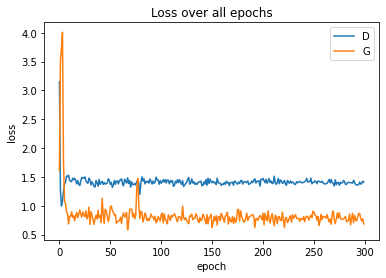

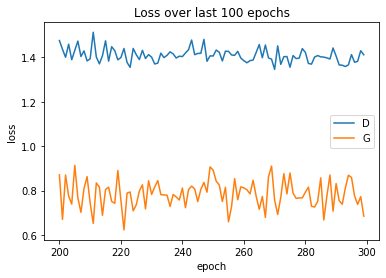

In [9]:
for i in range(len(D_losses)):
    D_losses[i] = D_losses[i].detach().cpu()
    G_losses[i] = G_losses[i].detach().cpu()

# plot the training and validation loss for the whole run
plt.plot(range(len(D_losses)), D_losses, label="D")
plt.plot(range(len(G_losses)), G_losses, label="G")
plt.legend()
plt.title("Loss over all epochs")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# plot the training and validation loss for the last 100 epochs to see a closer look
if (len(D_losses)) > 100:
    plt.plot(range(len(D_losses) - 100, len(D_losses)), D_losses[-100:], label="D")
    plt.plot(range(len(G_losses) - 100, len(G_losses)), G_losses[-100:], label="G")
    plt.legend()
    plt.title("Loss over last 100 epochs")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

## Save / Load the models to / from a file

The models are saved to "q4_gen_saved_network_weights.pt" and "q4_dis_saved_network_weights.pt" for the generator and discriminator. These are saved to and loaded from session storage.

In [10]:
# save the model
torch.save(netG.state_dict(), "gen_saved_network_weights.pt")
torch.save(netD.state_dict(), "dis_saved_network_weights.pt")

In [11]:
# load the model from a save file
netD = Discriminator()
netD = netD.to(device)
netD.load_state_dict(torch.load("dis_saved_network_weights.pt"))
netD.eval()

netG = Generator()
netG = netG.to(device)
netG.load_state_dict(torch.load("gen_saved_network_weights.pt"))
netG.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(256, 512, kernel_size=(9, 16), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Sigmoid()
  

## Visualise 8 of the generated landscapes

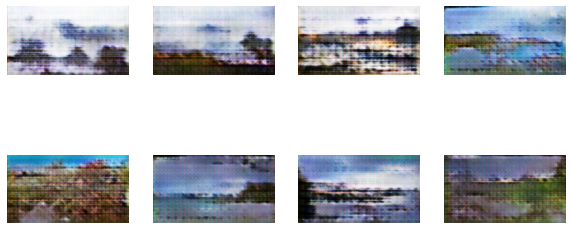

In [12]:
z = torch.randn(8,nz,1,1,device=device)
images = netG(z)

figure = plt.figure(figsize=(10, 5))
cols, rows = 4, 2
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(images[i,:].cpu().detach().permute(1, 2, 0))
plt.show()

## Interpolate between 2 generated landscapes

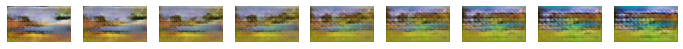

In [13]:
nsamples = 9
z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)
z = torch.zeros(nsamples,nz,1,1,device=device)
for i in range(nsamples):
    w1 = i/(nsamples-1)
    w2 = 1-w1
    z[i,:,:,:] = w1*z1 + w2*z2
images = netG(z)

figure = plt.figure(figsize=(12, 5))
for i in range(nsamples):
    figure.add_subplot(1, nsamples, i+1)
    plt.axis("off")
    plt.imshow(images[i,:].squeeze().cpu().detach().permute(1, 2, 0))
plt.show()